In [1]:
import numpy as np
import gensim
import tensorflow as tf

['text', 'spam']
5728
5728
5728
["Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three busines

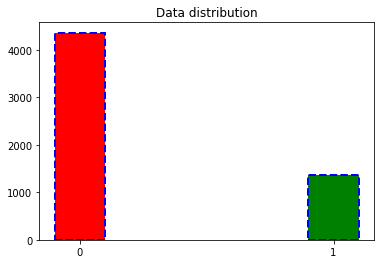

Punctuation: :
Punctuation: ;
Punctuation: ,
Punctuation: .
Punctuation: -
Punctuation: '
Punctuation: %
Punctuation: _
Punctuation: $
Punctuation: !
Punctuation: (
Punctuation: )
Punctuation: @
Punctuation: &
Punctuation: /
Punctuation: ?
Punctuation: |
Punctuation: *
Punctuation: "
Punctuation: +
Punctuation: =
Punctuation: >
Punctuation: #
Punctuation: [
Punctuation: ]
Punctuation: ^
Punctuation: }
Punctuation: <
Punctuation: ~
Punctuation: \
Punctuation: `
Punctuation: {
32
[':', ';', ',', '.', '-', "'", '%', '_', '$', '!', '(', ')', '@', '&', '/', '?', '|', '*', '"', '+', '=', '>', '#', '[', ']', '^', '}', '<', '~', '\\', '`', '{']
[('', 475161), ('the', 50110), ('to', 41734), ('and', 27478), ('of', 23757), ('a', 19943), ('you', 19149), ('in', 17972), ('i', 17421), ('for', 16696)]


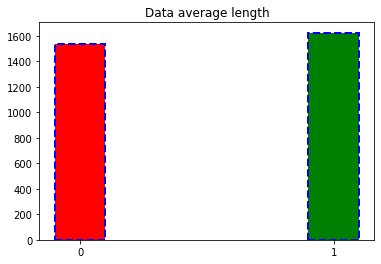

5728
Punctuation: :
Punctuation: ;
Punctuation: ,
Punctuation: .
Punctuation: -
Punctuation: '
Punctuation: %
Punctuation: _
Punctuation: $
Punctuation: !
Punctuation: (
Punctuation: )
Punctuation: @
Punctuation: &
Punctuation: /
Punctuation: ?
Punctuation: |
Punctuation: *
Punctuation: "
Punctuation: +
Punctuation: =
Punctuation: >
Punctuation: #
Punctuation: [
Punctuation: ]
Punctuation: ^
Punctuation: }
Punctuation: <
Punctuation: ~
Punctuation: \
Punctuation: `
Punctuation: {
[':', ';', ',', '.', '-', "'", '%', '_', '$', '!', '(', ')', '@', '&', '/', '?', '|', '*', '"', '+', '=', '>', '#', '[', ']', '^', '}', '<', '~', '\\', '`', '{']


In [2]:
from ipynb.fs.full.preprocessing import processRef
from ipynb.fs.full.data_analysis import readData, flatten_input, detect_punctuations

In [3]:
X, _ = readData("./data/Spam_Emails.csv")
concatenate_string, X_copy = flatten_input(X)
new_refs = processRef(X_copy) 

5728


In [4]:
y = np.load("./data/classes.npy")

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_refs, y, test_size=0.2, random_state=42)


In [6]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

4582
4582
1146
1146


## First approach

In [7]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [8]:
sequences = tokenizer.texts_to_sequences(X_train)

In [9]:
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
def scheduler(epoch, lr):
        if epoch < 5:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

In [12]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3), 
                    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)]

In [13]:
def build_model(vocab_size, embedding_dim, max_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model 

model = build_model(vocab_size, embedding_dim, max_length)
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.SGD(momentum=0.9),metrics=['accuracy', f1_metric])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 6)                 9606      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 25,613
Trainable params: 25,613
Non-trainable params: 0
_________________________________________________________________


In [14]:
history=model.fit(padded, y_train, epochs=20, validation_data=(testing_padded, y_test),callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/20
144/144 [==============================] - 1s 3ms/step - loss: 0.5343 - accuracy: 0.7630 - f1_metric: 0.0056 - val_loss: 0.4668 - val_accuracy: 0.7531 - val_f1_metric: 0.0517 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/20
144/144 [==============================] - 0s 2ms/step - loss: 0.3575 - accuracy: 0.8422 - f1_metric: 0.5100 - val_loss: 0.3081 - val_accuracy: 0.8534 - val_f1_metric: 0.5865 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/20
144/144 [==============================] - 0s 2ms/step - loss: 0.2428 - accuracy: 0.9027 - f1_metric: 0.7602 - val_loss: 0.2225 - val_accuracy: 0.9075 - val_f1_metric: 0.8012 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/20
144/144 [==============================] - 0s 2ms/step - loss: 0.1805 - accu

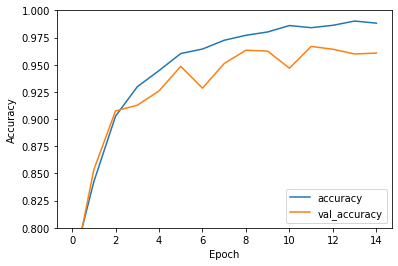

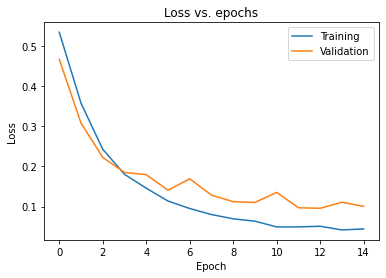

In [15]:
from matplotlib import pyplot as plt 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [16]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
padded = np.array(padded)
y_train = np.array(y_train)
y_test = np.array(y_test)
testing_padded = np.array(testing_padded)
y_pred = gnb.fit(padded, y_train).predict(testing_padded)
print("Number of mislabeled points out of a total %d points : %d"% (testing_padded.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 1146 points : 407


In [17]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='macro')

0.5906521435774297

## Second approach


In [18]:
import string

new_words = []
for word in X:
    for letter in word:
        if letter in string.punctuation:
            word = word.replace(letter,"")   
    new_words.append(word)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import copy

bigram_vect = TfidfVectorizer(ngram_range=(1,1))
temp = bigram_vect.fit_transform(X)
new_X = temp.toarray()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42)
del new_X

In [21]:
model2 = build_model(vocab_size, embedding_dim, 37303)

In [22]:
model2.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy', f1_metric])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 37303, 16)         16000     
                                                                 
 flatten_1 (Flatten)         (None, 596848)            0         
                                                                 
 dense_2 (Dense)             (None, 6)                 3581094   
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 3,597,101
Trainable params: 3,597,101
Non-trainable params: 0
_________________________________________________________________


In [23]:
history2=model2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=callbacks, batch_size=8)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
573/573 [==============================] - 16s 28ms/step - loss: 0.6556 - accuracy: 0.7608 - f1_metric: 0.0037 - val_loss: 0.6111 - val_accuracy: 0.7469 - val_f1_metric: 0.0000e+00 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
573/573 [==============================] - 16s 28ms/step - loss: 0.5814 - accuracy: 0.7647 - f1_metric: 0.0000e+00 - val_loss: 0.5782 - val_accuracy: 0.7469 - val_f1_metric: 0.0000e+00 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
573/573 [==============================] - 16s 28ms/step - loss: 0.5576 - accuracy: 0.7647 - f1_metric: 0.0000e+00 - val_loss: 0.5683 - val_accuracy: 0.7469 - val_f1_metric: 0.0000e+00 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
573/573 [==============================] - 16s